In [8]:

# **Objective:**
# Train the "Artist" (Stabilized U-Net) to segment faults from the seismic images.
# Define the "Engineer" (GAT) architecture for the application.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv
import torch.nn.functional as F

In [9]:
# ## 1. Stabilized U-Net Architecture
# (Matches the implementation in app.py)


class StabilizedUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = self.conv_block(1, 32); self.enc2 = self.conv_block(32, 64)
        self.pool = nn.MaxPool2d(2); self.bottleneck = self.conv_block(64, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2); self.dec2 = self.conv_block(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2); self.dec1 = self.conv_block(64, 32)
        self.final = nn.Conv2d(32, 1, kernel_size=1)

    def conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)
        )
    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool(e1); e2 = self.enc2(p1); p2 = self.pool(e2)
        b = self.bottleneck(p2); u2 = self.up2(b); u2 = torch.cat([u2, e2], dim=1)
        d2 = self.dec2(u2); u1 = self.up1(d2); u1 = torch.cat([u1, e1], dim=1)
        d1 = self.dec1(u1); return self.final(d1)

In [10]:
# ## 2. Data Loader
# Includes dilation to handle thin fault lines.

class SeismicDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images = sorted(os.listdir(f"{root_dir}/images"))

    def __len__(self): return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img = cv2.imread(f"{self.root_dir}/images/{img_name}", 0)
        mask = cv2.imread(f"{self.root_dir}/masks/{img_name}", 0)
        
        # Resize
        img = cv2.resize(img, (128, 128))
        mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_LINEAR)
        
        # Dilation to fix thin lines lost in resizing
        kernel = np.ones((3,3), np.uint8)
        mask = cv2.dilate(mask, kernel, iterations=1)
        _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
        
        # Normalize
        img = torch.tensor(img/255.0, dtype=torch.float32).unsqueeze(0)
        mask = torch.tensor(mask/255.0, dtype=torch.float32).unsqueeze(0)
        return img, mask

Epoch 1: Loss = 0.5784
Epoch 2: Loss = 0.4407
Epoch 3: Loss = 0.3804
Epoch 4: Loss = 0.3448
Epoch 5: Loss = 0.3218
Epoch 6: Loss = 0.3064
Epoch 7: Loss = 0.2949
Epoch 8: Loss = 0.2869
Epoch 9: Loss = 0.2785
Epoch 10: Loss = 0.2754
Epoch 11: Loss = 0.2660
Epoch 12: Loss = 0.2592
Epoch 13: Loss = 0.2544
Epoch 14: Loss = 0.2511
Epoch 15: Loss = 0.2509


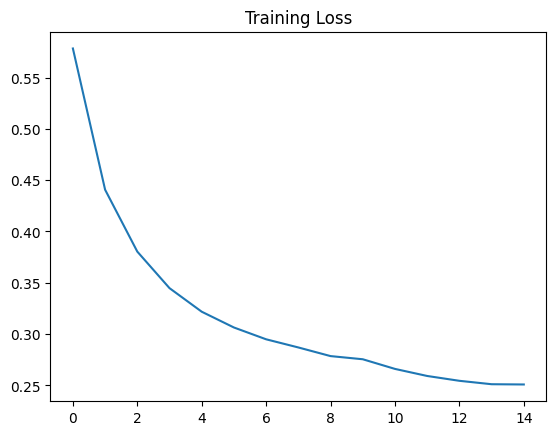

Saved Model: fault_model_stabilized.pth


In [13]:
# ## 3. Training Loop


# Ensure dataset exists before running
if os.path.exists("dataset_final"):
    dataset = SeismicDataset("dataset_final")
    loader = DataLoader(dataset, batch_size=8, shuffle=True)
    model = StabilizedUNet().to(DEVICE)

    # Weighted Loss to handle class imbalance
    pos_weight = torch.tensor([10.0]).to(DEVICE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

 
    loss_history = []
    
    for epoch in range(15): # 15 Epochs
        model.train()
        epoch_loss = 0
        for img, mask in loader:
            img, mask = img.to(DEVICE), mask.to(DEVICE)
            optimizer.zero_grad()
            output = model(img)
            loss = criterion(output, mask)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss/len(loader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

            # Plot Loss Curve
    plt.plot(loss_history)
    plt.title("Training Loss")
    plt.show()

    torch.save(model.state_dict(), "fault_model_stabilized.pth")
    print("Saved Model: fault_model_stabilized.pth")
else:
    print("Dataset not found! Run 01_Data_Engineering.ipynb first.")

In [14]:
# %%
class FaultGAT(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(FaultGAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_channels, heads=4, dropout=0.0)
        self.conv2 = GATConv(hidden_channels * 4, num_classes, heads=1, concat=False, dropout=0.0)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Save Dummy Weights for App
model_gat = FaultGAT(3, 16, 2)
torch.save(model_gat.state_dict(), "gat_model_complete.pth")
print("Saved GAT Weights.")

Saved GAT Weights.


In [15]:
# **Objective:**
# 1. Train "The Artist" (Stabilized U-Net) to see faults.
# 2. Train "The Engineer" (GAT) to understand physics rules (Vertical = Risk).
# 3. Demonstrate the full "Image-to-Graph" Neuro-Symbolic pipeline.


import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from skimage.morphology import skeletonize
from scipy.spatial import KDTree
import networkx as nx
import random

In [16]:
BASE_FOLDER = "dataset_final"
IMG_SIZE = 128
BATCH_SIZE = 8
EPOCHS = 15 # Fast training for demo
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Initializing Protean Engine on {DEVICE.upper()}...")


# ## 1. Define Stabilized U-Net
# Uses Batch Normalization to stabilize gradients on noisy seismic data.

# %%
class StabilizedUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = self.conv_block(1, 32); self.enc2 = self.conv_block(32, 64)
        self.pool = nn.MaxPool2d(2); self.bottleneck = self.conv_block(64, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2); self.dec2 = self.conv_block(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2); self.dec1 = self.conv_block(64, 32)
        self.final = nn.Conv2d(32, 1, kernel_size=1)
    
    def conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c), nn.ReLU(True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c), nn.ReLU(True)
        )
    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool(e1); e2 = self.enc2(p1); p2 = self.pool(e2)
        b = self.bottleneck(p2); u2 = self.up2(b); u2 = torch.cat([u2, e2], dim=1)
        d2 = self.dec2(u2); u1 = self.up1(d2); u1 = torch.cat([u1, e1], dim=1)
        d1 = self.dec1(u1); return self.final(d1)

# ## 2. Train The Artist
# Loads data from `dataset_final`, trains the U-Net, and saves the weights.

class SeismicDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images = sorted(os.listdir(f"{root_dir}/images"))
    def __len__(self): return len(self.images)
    def __getitem__(self, idx):
        img = cv2.imread(f"{self.root_dir}/images/{self.images[idx]}", 0)
        mask = cv2.imread(f"{self.root_dir}/masks/{self.images[idx]}", 0)
        # Preprocessing: Resize & Dilate thin lines
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
        kernel = np.ones((3,3), np.uint8)
        mask = cv2.dilate(mask, kernel, iterations=1)
        _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
        # To Tensor
        return torch.tensor(img/255.0, dtype=torch.float32).unsqueeze(0), torch.tensor(mask/255.0, dtype=torch.float32).unsqueeze(0)

# Run Training
if os.path.exists(BASE_FOLDER):
    dataset = SeismicDataset(BASE_FOLDER)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model = StabilizedUNet().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Weighted Loss for class imbalance
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10.0]).to(DEVICE))

    print("Training The Artist (U-Net)...")
    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0
        for img, mask in loader:
            img, mask = img.to(DEVICE), mask.to(DEVICE)
            optimizer.zero_grad()
            out = model(img)
            loss = criterion(out, mask)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if (epoch+1)%5 == 0: print(f"   Epoch {epoch+1}/{EPOCHS} Loss: {epoch_loss/len(loader):.4f}")

    torch.save(model.state_dict(), "fault_model_stabilized.pth")
    print("Saved: fault_model_stabilized.pth")
else:
    print(" Dataset not found! Run Notebook 01 first.")

Initializing Protean Engine on CPU...
Training The Artist (U-Net)...
   Epoch 5/15 Loss: 0.4133
   Epoch 10/15 Loss: 0.3171
   Epoch 15/15 Loss: 0.2738
Saved: fault_model_stabilized.pth


In [17]:
# ## 3. Define Graph Neural Network (GAT)
# This model takes nodes (fault segments) and decides if they are risky based on geometry.


class FaultGAT(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(FaultGAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_channels, heads=4, dropout=0.0)
        self.conv2 = GATConv(hidden_channels * 4, num_classes, heads=1, concat=False, dropout=0.0)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

def image_to_graph_pipeline(binary_mask):
    """Converts a binary fault mask into a Graph (Nodes & Edges)"""
    skel = skeletonize(binary_mask)
    if np.sum(skel) == 0: return None, None
    
    # Build Graph Nodes from pixels
    pts = np.column_stack(np.where(skel > 0))
    G = nx.Graph()
    for p in pts: G.add_node(tuple(p), pos=(p[1], p[0]))
    
    # Connect nearby pixels
    if len(pts) > 1:
        tree = KDTree(pts)
        pairs = tree.query_pairs(r=2.5)
        for i,j in pairs: G.add_edge(tuple(pts[i]), tuple(pts[j]))
        
    # Prune tiny noise
    if G.number_of_nodes() < 5: return None, None

    # Extract Physics Features (Depth, Dip, Amplitude)
    node_features = []
    node_list = list(G.nodes())
    for node in node_list:
        r, c = node
        depth = r / 128.0
        # Calculate Dip (Verticality)
        is_vert = False
        for n in G.neighbors(node):
            if abs(r - n[0]) > abs(c - n[1]): is_vert = True; break
        dip = 1.0 if is_vert else 0.1
        node_features.append([depth, dip, 0.5]) # [Depth, Dip, Amp]

    # Convert to PyG Data
    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = []
    for u, v in G.edges():
        u_idx, v_idx = node_list.index(u), node_list.index(v)
        edge_index.extend([[u_idx, v_idx], [v_idx, u_idx]])
    
    if not edge_index: return None, None
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    
    # Rule-Based Ground Truth for Training: Deep + Vertical = Risk
    y = torch.tensor([1 if (f[0]>0.3 and f[1]>0.8) else 0 for f in node_features], dtype=torch.long)
    
    return Data(x=x, edge_index=edge_index, y=y), G

In [18]:
# ## 4. Train The Engineer
# We train the GNN on a synthetic "Physics Simulation" (simulated mask).

print("Training 'The Engineer' on Physics Rules...")
# Create synthetic data: Vertical line (Risk) and Horizontal line (Safe)
sim_mask = np.zeros((128, 128), dtype=bool)
sim_mask[20:110, 40] = 1 # Vertical
sim_mask[30, 20:110] = 1 # Horizontal

train_data, _ = image_to_graph_pipeline(sim_mask)
train_data = train_data.to(DEVICE)

risk_model = FaultGAT(3, 16, 2).to(DEVICE)
optimizer = optim.Adam(risk_model.parameters(), lr=0.01)

risk_model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = risk_model(train_data)
    loss = F.nll_loss(out, train_data.y)
    loss.backward()
    optimizer.step()

torch.save(risk_model.state_dict(), "gat_model_complete.pth")
print("Saved: gat_model_complete.pth")

Training 'The Engineer' on Physics Rules...
Saved: gat_model_complete.pth


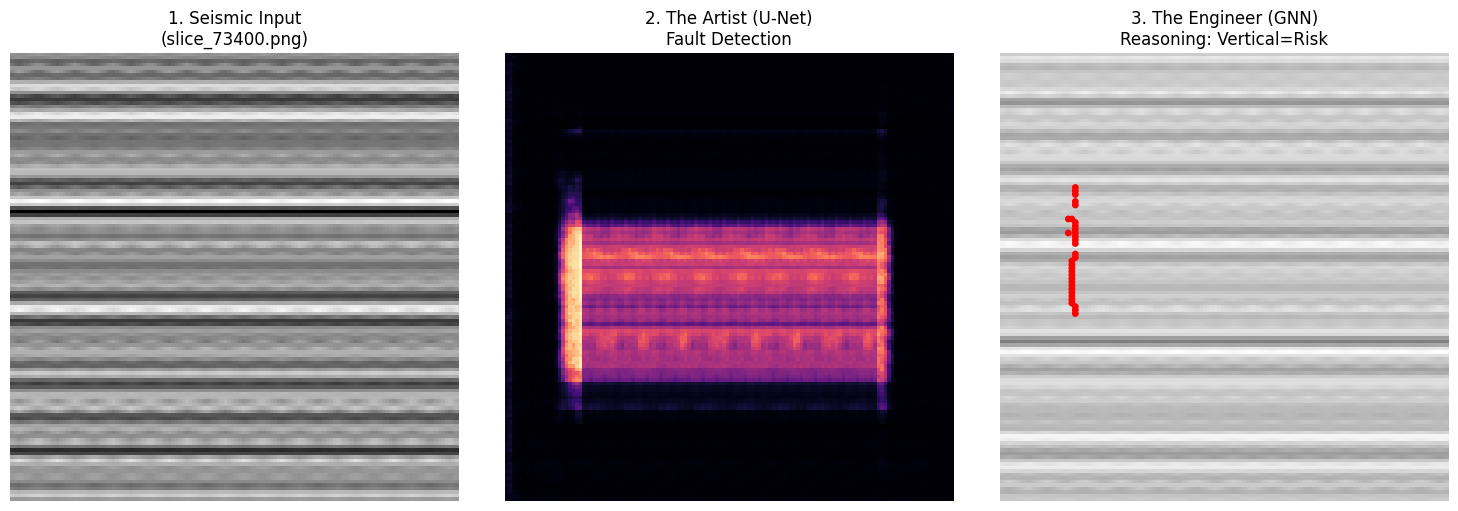

In [29]:
# ## 5. Run Neuro-Symbolic Pipeline
# 1. Load a random test image.
# 2. U-Net predicts the Fault Mask.
# 3. GNN analyzes the Mask for Risk.
# 4. Plot the result (Red = High Risk, Green = Low Risk).


vision_model = StabilizedUNet().to(DEVICE)
vision_model.load_state_dict(torch.load("fault_model_stabilized.pth", map_location=DEVICE))
vision_model.eval()

risk_model.eval()
found = False
while not found:
    random_file = random.choice(os.listdir(f"{BASE_FOLDER}/images"))
    gt = cv2.imread(f"{BASE_FOLDER}/masks/{random_file}", 0)
    if gt.max() > 0: found = True

# A. Vision Prediction
original_img = cv2.imread(f"{BASE_FOLDER}/images/{random_file}", 0)
input_img = cv2.resize(original_img, (128, 128))
tensor_img = torch.tensor(input_img/255.0, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)

with torch.no_grad():
    pred = vision_model(tensor_img)
    pred_prob = torch.sigmoid(pred).squeeze().cpu().numpy()

# B. Graph Reasoning
geo_data, G_pruned = image_to_graph_pipeline(pred_prob > 0.5)

if geo_data:
    geo_data = geo_data.to(DEVICE)
    with torch.no_grad():
        risk_logits = risk_model(geo_data)
        preds = risk_logits.argmax(dim=1).cpu().numpy()

    plt.figure(figsize=(15, 5))
    
    # 1. Seismic Input
    plt.subplot(1, 3, 1)
    plt.imshow(input_img, cmap='gray')
    plt.title(f"1. Seismic Input\n({random_file})")
    plt.axis('off')
    
    # 2. Vision Output
    plt.subplot(1, 3, 2)
    plt.imshow(pred_prob, cmap='magma')
    plt.title("2. The Artist (U-Net)\nFault Detection")
    plt.axis('off')
    
    # 3. Reasoning Output
    plt.subplot(1, 3, 3)
    plt.imshow(input_img, cmap='gray', alpha=0.5)
    pos = {n: (n[1], n[0]) for n in G_pruned.nodes()}
    # Color logic: Red if Risk, Green if Safe
    colors = ['red' if p==1 else '#00FF00' for p in preds]
    nx.draw(G_pruned, pos, node_size=15, node_color=colors, edge_color='cyan', width=0.5)
    plt.title(f"3. The Engineer (GNN)\nReasoning: Vertical=Risk")
    plt.gca().invert_yaxis()
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No clean graph found in this image. Run cell again for another sample.")

Initializing Protean Engine on CPU...
Training The Artist (U-Net)...
   Epoch 5/15 Loss: 0.3216
   Epoch 10/15 Loss: 0.2763
   Epoch 15/15 Loss: 0.2478
Saved: fault_model_stabilized.pth
Training 'The Engineer' on Physics Rules...
Saved: gat_model_complete.pth


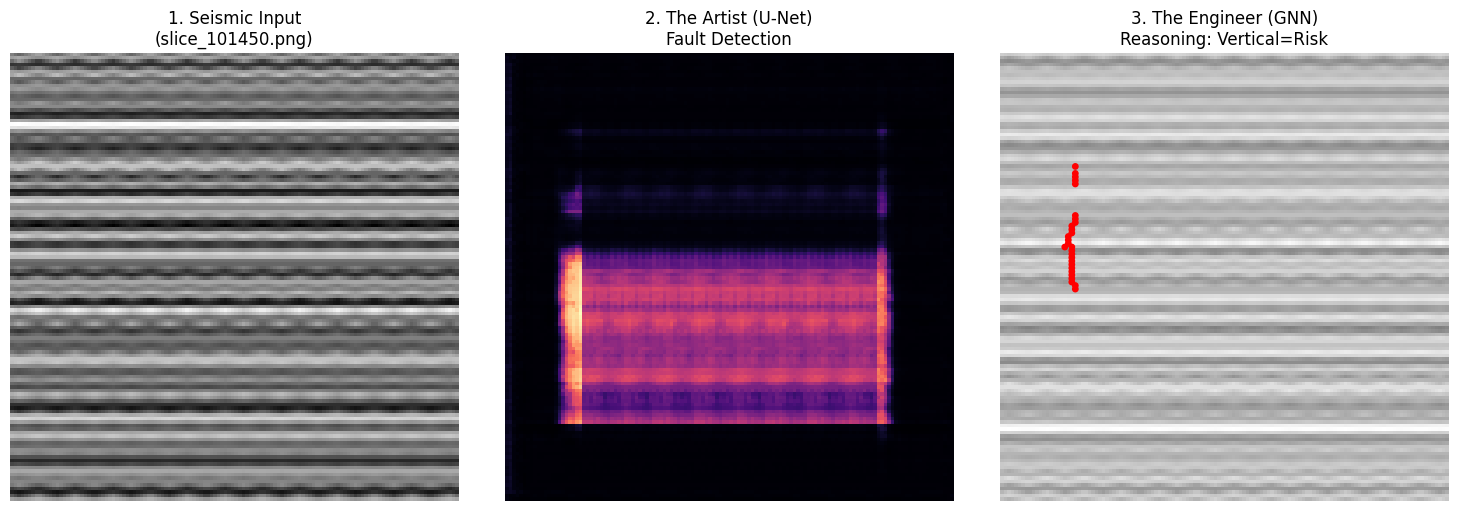

In [20]:


BASE_FOLDER = "dataset_final"
IMG_SIZE = 128
BATCH_SIZE = 8
EPOCHS = 15 # Fast training for demo
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Initializing Protean Engine on {DEVICE.upper()}...")


# ## 1. Define Stabilized U-Net
# Uses Batch Normalization to stabilize gradients on noisy seismic data.

# %%
class StabilizedUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = self.conv_block(1, 32); self.enc2 = self.conv_block(32, 64)
        self.pool = nn.MaxPool2d(2); self.bottleneck = self.conv_block(64, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2); self.dec2 = self.conv_block(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2); self.dec1 = self.conv_block(64, 32)
        self.final = nn.Conv2d(32, 1, kernel_size=1)
    
    def conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c), nn.ReLU(True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c), nn.ReLU(True)
        )
    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool(e1); e2 = self.enc2(p1); p2 = self.pool(e2)
        b = self.bottleneck(p2); u2 = self.up2(b); u2 = torch.cat([u2, e2], dim=1)
        d2 = self.dec2(u2); u1 = self.up1(d2); u1 = torch.cat([u1, e1], dim=1)
        d1 = self.dec1(u1); return self.final(d1)

# ## 2. Train The Artist
# Loads data from `dataset_final`, trains the U-Net, and saves the weights.

class SeismicDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images = sorted(os.listdir(f"{root_dir}/images"))
    def __len__(self): return len(self.images)
    def __getitem__(self, idx):
        img = cv2.imread(f"{self.root_dir}/images/{self.images[idx]}", 0)
        mask = cv2.imread(f"{self.root_dir}/masks/{self.images[idx]}", 0)
        # Preprocessing: Resize & Dilate thin lines
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
        kernel = np.ones((3,3), np.uint8)
        mask = cv2.dilate(mask, kernel, iterations=1)
        _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
        # To Tensor
        return torch.tensor(img/255.0, dtype=torch.float32).unsqueeze(0), torch.tensor(mask/255.0, dtype=torch.float32).unsqueeze(0)

# Run Training
if os.path.exists(BASE_FOLDER):
    dataset = SeismicDataset(BASE_FOLDER)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model = StabilizedUNet().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Weighted Loss for class imbalance
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10.0]).to(DEVICE))

    print("Training The Artist (U-Net)...")
    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0
        for img, mask in loader:
            img, mask = img.to(DEVICE), mask.to(DEVICE)
            optimizer.zero_grad()
            out = model(img)
            loss = criterion(out, mask)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if (epoch+1)%5 == 0: print(f"   Epoch {epoch+1}/{EPOCHS} Loss: {epoch_loss/len(loader):.4f}")

    torch.save(model.state_dict(), "fault_model_stabilized.pth")
    print("Saved: fault_model_stabilized.pth")
else:
    print(" Dataset not found! Run Notebook 01 first.")



# ## 3. Define Graph Neural Network (GAT)
# This model takes nodes (fault segments) and decides if they are risky based on geometry.


class FaultGAT(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(FaultGAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_channels, heads=4, dropout=0.0)
        self.conv2 = GATConv(hidden_channels * 4, num_classes, heads=1, concat=False, dropout=0.0)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

def image_to_graph_pipeline(binary_mask):
    """Converts a binary fault mask into a Graph (Nodes & Edges)"""
    skel = skeletonize(binary_mask)
    if np.sum(skel) == 0: return None, None
    
    # Build Graph Nodes from pixels
    pts = np.column_stack(np.where(skel > 0))
    G = nx.Graph()
    for p in pts: G.add_node(tuple(p), pos=(p[1], p[0]))
    
    # Connect nearby pixels
    if len(pts) > 1:
        tree = KDTree(pts)
        pairs = tree.query_pairs(r=2.5)
        for i,j in pairs: G.add_edge(tuple(pts[i]), tuple(pts[j]))
        
    # Prune tiny noise
    if G.number_of_nodes() < 5: return None, None

    # Extract Physics Features (Depth, Dip, Amplitude)
    node_features = []
    node_list = list(G.nodes())
    for node in node_list:
        r, c = node
        depth = r / 128.0
        # Calculate Dip (Verticality)
        is_vert = False
        for n in G.neighbors(node):
            if abs(r - n[0]) > abs(c - n[1]): is_vert = True; break
        dip = 1.0 if is_vert else 0.1
        node_features.append([depth, dip, 0.5]) # [Depth, Dip, Amp]

    # Convert to PyG Data
    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = []
    for u, v in G.edges():
        u_idx, v_idx = node_list.index(u), node_list.index(v)
        edge_index.extend([[u_idx, v_idx], [v_idx, u_idx]])
    
    if not edge_index: return None, None
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    
    # Rule-Based Ground Truth for Training: Deep + Vertical = Risk
    y = torch.tensor([1 if (f[0]>0.3 and f[1]>0.8) else 0 for f in node_features], dtype=torch.long)
    
    return Data(x=x, edge_index=edge_index, y=y), G

# ## 4. Train The Engineer
# We train the GNN on a synthetic "Physics Simulation" (simulated mask).

print("Training 'The Engineer' on Physics Rules...")
# Create synthetic data: Vertical line (Risk) and Horizontal line (Safe)
sim_mask = np.zeros((128, 128), dtype=bool)
sim_mask[20:110, 40] = 1 # Vertical
sim_mask[30, 20:110] = 1 # Horizontal

train_data, _ = image_to_graph_pipeline(sim_mask)
train_data = train_data.to(DEVICE)

risk_model = FaultGAT(3, 16, 2).to(DEVICE)
optimizer = optim.Adam(risk_model.parameters(), lr=0.01)

risk_model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = risk_model(train_data)
    loss = F.nll_loss(out, train_data.y)
    loss.backward()
    optimizer.step()

torch.save(risk_model.state_dict(), "gat_model_complete.pth")
print("Saved: gat_model_complete.pth")


# ## 5. Run Neuro-Symbolic Pipeline
# 1. Load a random test image.
# 2. U-Net predicts the Fault Mask.
# 3. GNN analyzes the Mask for Risk.
# 4. Plot the result (Red = High Risk, Green = Low Risk).


vision_model = StabilizedUNet().to(DEVICE)
vision_model.load_state_dict(torch.load("fault_model_stabilized.pth", map_location=DEVICE))
vision_model.eval()

risk_model.eval()
found = False
while not found:
    random_file = random.choice(os.listdir(f"{BASE_FOLDER}/images"))
    gt = cv2.imread(f"{BASE_FOLDER}/masks/{random_file}", 0)
    if gt.max() > 0: found = True

# A. Vision Prediction
original_img = cv2.imread(f"{BASE_FOLDER}/images/{random_file}", 0)
input_img = cv2.resize(original_img, (128, 128))
tensor_img = torch.tensor(input_img/255.0, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)

with torch.no_grad():
    pred = vision_model(tensor_img)
    pred_prob = torch.sigmoid(pred).squeeze().cpu().numpy()

# B. Graph Reasoning
geo_data, G_pruned = image_to_graph_pipeline(pred_prob > 0.5)

if geo_data:
    geo_data = geo_data.to(DEVICE)
    with torch.no_grad():
        risk_logits = risk_model(geo_data)
        preds = risk_logits.argmax(dim=1).cpu().numpy()

    plt.figure(figsize=(15, 5))
    
    # 1. Seismic Input
    plt.subplot(1, 3, 1)
    plt.imshow(input_img, cmap='gray')
    plt.title(f"1. Seismic Input\n({random_file})")
    plt.axis('off')
    
    # 2. Vision Output
    plt.subplot(1, 3, 2)
    plt.imshow(pred_prob, cmap='magma')
    plt.title("2. The Artist (U-Net)\nFault Detection")
    plt.axis('off')
    
    # 3. Reasoning Output
    plt.subplot(1, 3, 3)
    plt.imshow(input_img, cmap='gray', alpha=0.5)
    pos = {n: (n[1], n[0]) for n in G_pruned.nodes()}
    # Color logic: Red if Risk, Green if Safe
    colors = ['red' if p==1 else '#00FF00' for p in preds]
    nx.draw(G_pruned, pos, node_size=15, node_color=colors, edge_color='cyan', width=0.5)
    plt.title(f"3. The Engineer (GNN)\nReasoning: Vertical=Risk")
    plt.gca().invert_yaxis()
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No clean graph found in this image. Run cell again for another sample.")